<a href="https://colab.research.google.com/github/rajeevak40/Shareprice_Prediction/blob/main/StockPrice_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#Import Libraraies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from datetime import date
from datetime import datetime
from datetime import timedelta
import time
import tensorflow as tf


In [3]:
end_date = date.today()
print("Today's date:", end_date)
start_date = end_date - timedelta(days=365*10)
period_2=int(datetime.timestamp(datetime.today()))
period_1= int(datetime.timestamp(datetime.now()-timedelta(days=365*10)))
stock= input("Enter Ticker Code as per Yahoo : ")
print(period_1)
print(period_2)

Today's date: 2021-07-20
Enter Ticker Code as per Yahoo : KOTAKBANK.NS
1311379517
1626739517


In [4]:
query=f'https://query1.finance.yahoo.com/v7/finance/download/{stock}?period1={period_1}&period2={period_2}&interval=1d&events=history&includeAdjustedClose=true'


In [5]:
# Get stock quote

df= pd.read_csv(query)
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-07-25,242.949997,244.199997,238.350006,243.399994,241.964401,1333738.0
1,2011-07-26,244.199997,245.000000,231.425003,233.050003,231.675446,2283662.0
2,2011-07-27,234.500000,234.975006,226.574997,231.699997,230.333405,1725224.0
3,2011-07-28,232.000000,233.949997,227.000000,229.225006,227.873001,3260604.0
4,2011-07-29,229.225006,229.225006,220.675003,222.524994,221.212509,2762068.0
5,2011-08-01,224.500000,229.875000,223.675003,227.100006,225.760529,1553792.0
6,2011-08-02,225.649994,229.824997,223.125000,228.949997,227.599625,3412910.0
7,2011-08-03,225.274994,231.800003,225.250000,229.300003,227.947571,2342076.0
8,2011-08-04,230.324997,231.500000,225.125000,225.875000,224.542770,2016428.0
9,2011-08-05,219.000000,224.500000,216.250000,219.875000,218.578140,3128488.0


In [153]:
df.isnull().sum()

Date         0
Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64

In [154]:
df=df.dropna(axis=0)

In [156]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

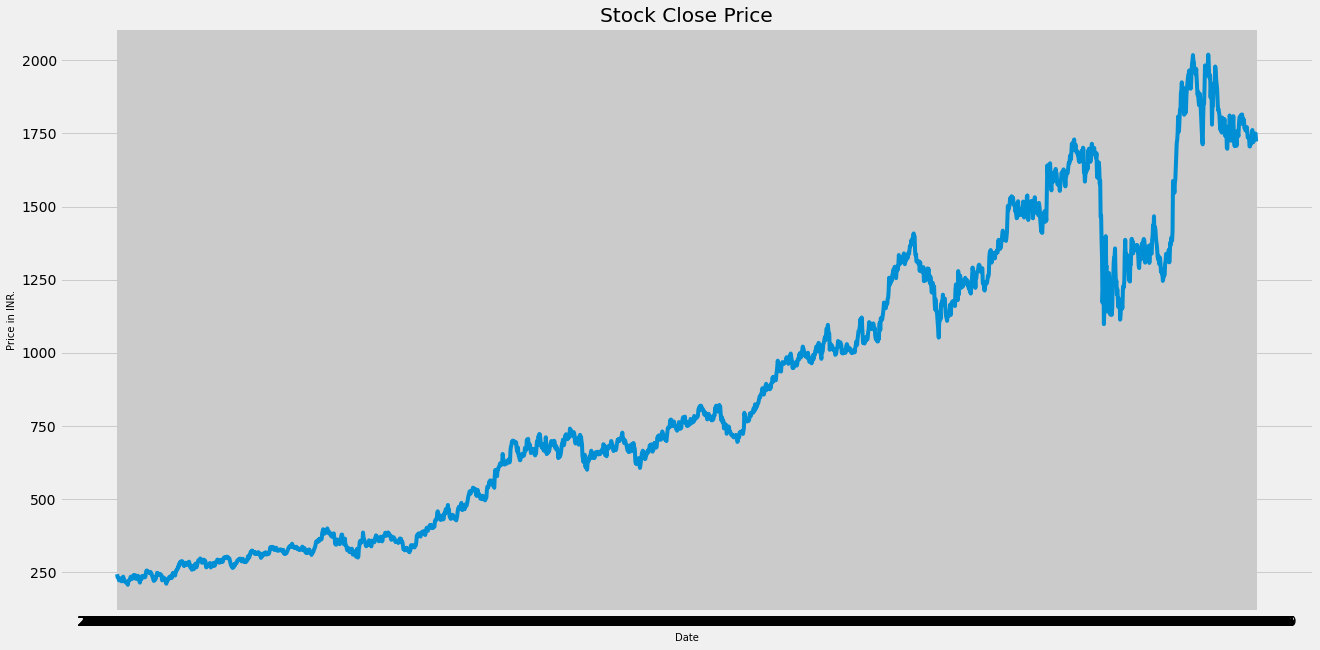

In [155]:
plt.figure(figsize=(20,10))
plt.title( "Stock Close Price")
plt.plot(df['Date'],df['Close'])
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price in INR.', fontsize=10)
plt.show()

In [157]:
data= df.filter(['Close'])

#  Convert to numpy array
dataset= data.values

# No of rows for taining.
train_data_len = math.ceil(len(dataset)*.8)

In [158]:
# Scaling data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01993241],
       [0.01422168],
       [0.01347679],
       ...,
       [0.85124493],
       [0.85094143],
       [0.83620941]])

In [159]:
# Computation of Time lag
time_lag=20

In [160]:
# Create Data Matrix function
def create_datset(dataset, time_lag):
    dataX, dataY =[], []
    for i in range( time_lag, len(dataset)-time_lag-1):
        a= dataset[i: i+time_lag,0]
        dataX.append(a)
        dataY.append(dataset[i+time_lag,0])
    return np.array(dataX), np.array(dataY)


In [161]:
# Create Training & Test Data Set

train_data, test_data = scaled_data[0:train_data_len],scaled_data[train_data_len:len(scaled_data)]
X_train, Y_train = create_datset(train_data, time_lag)
X_test, Y_test = create_datset(test_data, time_lag)


In [162]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1924, 20), (1924,), (450, 20), (450,))

In [163]:
# Reshaping data to 3 deminsional date for LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [164]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1924, 20, 1), (1924,), (450, 20, 1), (450,))

In [165]:
sum=np.sum(X_train)
np.isnan(sum)

False

In [193]:
model= Sequential([
                   tf.keras.layers.LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'sigmoid', input_shape=(X_train.shape[1],1)),
                   tf.keras.layers.LSTM(50,  activation='tanh', return_sequences=True, recurrent_activation = 'sigmoid'),
                   tf.keras.layers.LSTM(20,  activation='tanh', return_sequences=True, recurrent_activation = 'sigmoid'),
                   tf.keras.layers.Dense(1)
                                ])

model.compile(loss= tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics=tf.keras.metrics.RootMeanSquaredError())

history=model.fit(X_train, Y_train, epochs=100, verbose=0)


In [1]:
plt.plot(pd.DataFrame (history.history))
plt.legend.show()

NameError: ignored

# Model Prediction


In [195]:
# Prediction of prce on Test dataset
predictions =model.predict(X_test)
model.evaluate(predictions, Y_test)

15/15 [==============================] - 1s 9ms/step - loss: 0.0045 - root_mean_squared_error: 0.0221


[0.004542856011539698, 0.022115003317594528]

In [196]:
# Get RMSE on Prediction
rmse= np.sqrt(np.mean(predictions-Y_test)**2)
rmse

0.016763528558205232

In [218]:
#forcast= scaler.inverse_transform(predictions)

forecast=pd.DataFrame(predictions)
forecast.head()

ValueError: ignored

ValueError: ignored

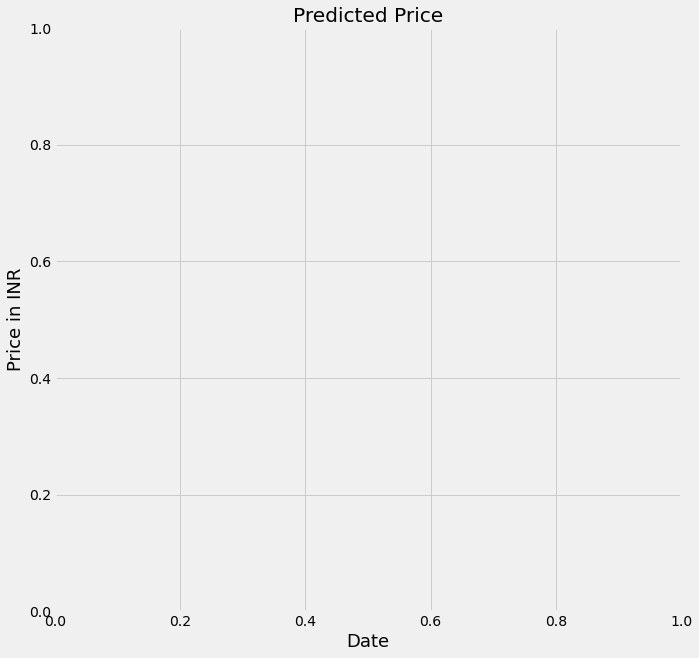

In [224]:
# Plotting the price
plt.figure(figsize=(10,10))
plt.title("Predicted Price")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price in INR", fontsize=18)
plt.plot(predictions)
plt.plot(Y_test)
plt.legend(["Prediction","Test"], loc ='lower right')
plt.show()

# predictions[0:]